<h1>Sampling Methods</h1>
<p>by: Andrew Fillmore</p>
<p>fillmore1@llnl.gov</p>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

<h2>The Trata Package</h2>
<p>The <b>Trata</b> package exists as a pip package with 4 modules: <code>sampler</code>,  <code>adaptive_sampler</code>, <code>kosh_sampler</code>, and <code>composite_samples</code>.</p>
<p>The <code>sampler</code> module defines a number of different samplers, as well as a heirarchy of base classes for these samplers. It is possible to create your own sampler by extending one of these base classes.</p>
<p>The <code>adaptive_sampler</code> module chooses the best set of samples to add to an existing dataset based on your choice of scoring algorithms.
<p>The <code>kosh_sampler</code> makes it easier to use Trata samplers as an operator on data in Kosh stores. 
<p>The <code>composite_samples</code> module defines an object that can use several different samplers to create and hold a set of sample points.</p>

In [2]:
from trata import sampler, adaptive_sampler, kosh_sampler, composite_samples

<h2>The sampler Module</h2>
<p>All samplers in the <code>samples</code> module implement <code>sample_points()</code>. This method takes a set of keyword arguemnts and returns a 2d numpy array of sample points.</p> 
<p>To create a set of points, simply call the <code>SamplePoints()</code> method with the required keywords.</p>
<p>Here we are creating a set of 10 points in the 3 dimensional unit cube using a Latin Hyper-Cube technique.</p>

In [3]:
myLHSampler = sampler.LatinHyperCubeSampler()
lhsPoints = myLHSampler.sample_points(num_points=10, box=[[0, 1], [0, 1], [0, 1]], seed=3)
print(lhsPoints)

[[0.5207242878138187 0.8156867738474963 0.6713565747153497]
 [0.40514672033008303 0.35446490180318446 0.20231175662953743]
 [0.14408098436506364 0.9780314764511367 0.3315767246533334]
 [0.2029876210878567 0.030636353237617975 0.05627700944910962]
 [0.9456833224394711 0.12219578839321815 0.774815743617144]
 [0.6649144047614761 0.43879712575556495 0.8609623665301449]
 [0.7278487282647976 0.7936383649860431 0.4203354525995899]
 [0.06762549019801313 0.5975995422472934 0.5653630851660177]
 [0.35908628174163515 0.6672383675912814 0.1662686270372964]
 [0.8023981882377167 0.29028341085383985 0.987107204857087]]


<p>These points are organized such that each column corresponds with a dimension and each row coresponds with a point.</p>

In [4]:
dimension0 = lhsPoints[:, 0]
print(dimension0)
print("There are {} values in this dimension".format(len(dimension0)))

[0.5207242878138187 0.40514672033008303 0.14408098436506364
 0.2029876210878567 0.9456833224394711 0.6649144047614761
 0.7278487282647976 0.06762549019801313 0.35908628174163515
 0.8023981882377167]
There are 10 values in this dimension


In [5]:
point0 = lhsPoints[0, :]
print(point0)
print("This point is {} dimensional".format(len(point0)))

[0.5207242878138187 0.8156867738474963 0.6713565747153497]
This point is 3 dimensional


<p>Each sampler object will have a different implementation of <code>sample_points()</code> and often will have its own unique set of keyword arguments.</p><p>For instance in <code>CartesianCrossSampler</code> the points are generated by taking the cartesian cross product of a set of divisions in each dimension. It requires that the number of divisions in each dimension be specified.</p><p>Here we generate 20 points with 5 division in the 0th dimension and 4 divisions in the 1st dimension</p>

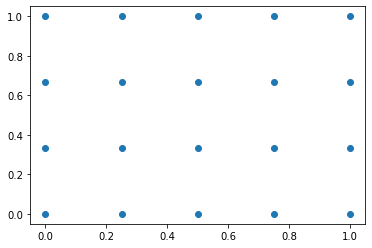

In [6]:
myCCSampler = sampler.CartesianCrossSampler()
ccPoints = myCCSampler.sample_points(num_divisions=[5, 4], box=[[0, 1], [0, 1]]).T
plt.scatter(ccPoints[0], ccPoints[1])

<p><code>sample_points()</code> is a static method. Thus it can be accessed directly from any sampler without having to instatiate it.</p>

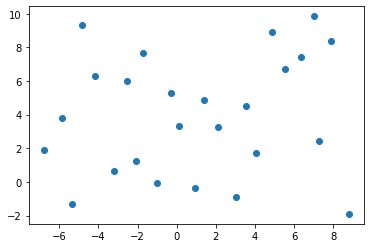

In [7]:
lhsStaticPoints = sampler.LatinHyperCubeSampler.sample_points(num_points=25, box=[[-7.0, 9.0], [-2.0, 10.0]], seed=3).T
plt.scatter(lhsStaticPoints[0], lhsStaticPoints[1])

<b>The list of all implemented samplers can be accessed at the <a href="https://lc.llnl.gov/confluence/display/UQP">UQ pipline wiki</a> </b>

<h2>The adaptive_sampler Module</h2>
<p>The <code>adaptive_sampler</code> module offers a choice of algorithms to choose the next best samples for model improvement or input space coverage.</p>
<p>All samplers in the <code>adaptive_sampler</code> module implement <code>sample_points()</code>. This method takes a set of keyword arguemnts and returns a 2d numpy array of sample points.</p>

</p>First we will use the <code>ActiveLearningSampler</code> to find the next 3 best samples out of candidate samples that are generated with the Latin-hypercube sampler from the <code>sampler</code> module. We start with 50 input samples and get the output with our model.</p>

In [8]:
from sklearn.datasets import make_blobs
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
# Create some clustered data
train_input, y = make_blobs(n_samples=50, centers=3, n_features=2, random_state=3)

def my_model(np_input):
    np_input = np_input.astype(float)
    out = np.sin(np_input[:, 0]) + np.cos(np_input[:, 1])
    return out.reshape(-1, 1)

# Get the output values from our model
train_output = my_model(train_input)

# Train a surrogate model
surrogate_model = gpr().fit(train_input, train_output)

<p>Now we use the active learning sampler to return the 3 best candidate points. The surrogate model will provide the uncertainty of the model at each candidate point, and the more uncertainty, the higher the score for that candidate point.</p>

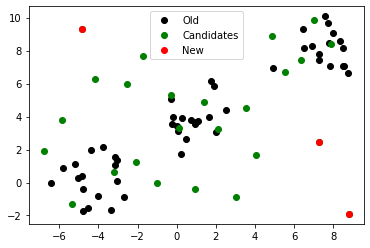

In [9]:
new_samples = adaptive_sampler.ActiveLearningSampler.sample_points(num_points=3,
                                                                         cand_points=lhsStaticPoints.T,
                                                                         model=surrogate_model,
                                                                         seed=3)

plt.plot(train_input[:,0], train_input[:,1], 'ko', label="Old")
plt.plot(lhsStaticPoints.T[:,0], lhsStaticPoints.T[:,1], 'go', label="Candidates")
plt.plot(new_samples[:,0], new_samples[:,1], 'ro', label="New")
plt.legend()

</p>Now we will try the <code>BestCandidateSampler</code> to do the same thing, but this time the candidate samples are scored based on just the distance between them and existing input samples. We don't consider model or surrogate model output.</p>

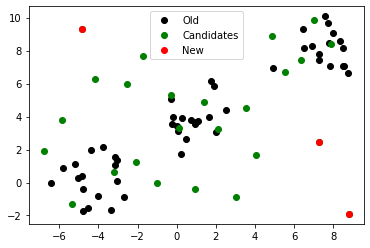

In [10]:
new_samples = adaptive_sampler.BestCandidateSampler.sample_points(num_points=3,
                                                                         X=train_input,
                                                                         cand_points=lhsStaticPoints.T,
                                                                         seed=3)

plt.plot(train_input[:,0], train_input[:,1], 'ko', label="Old")
plt.plot(lhsStaticPoints.T[:,0], lhsStaticPoints.T[:,1], 'go', label="Candidates")
plt.plot(new_samples[:,0], new_samples[:,1], 'ro', label="New")
plt.legend()

<h2>The composite_samples Module</h2>
<p>The <code>composite_samples</code> module provides a way to generate a collated set of points from multiple samplers.</p>
<p> The primary object that <code>composite_samples</code> provides is the <code>Samples</code> object.</p> 

In [11]:
mySamples = composite_samples.Samples()

<p>To use a <code>Samples</code> object, first add the variables you want to sample on. This includes a name, lower extent, upper extent, and default value.</p>
<p>Here we add two continuous variables. 'X' has a range of [-2,3] and a default value of 2. 'Y' has a range of [4,5] and a default value of 4.2.</p>

In [12]:
mySamples.set_continuous_variable('X', -2.0, 2.0, 3.0)
mySamples.set_continuous_variable('Y',  4.0, 4.2, 5.0)

<p>To generate samples based on these variables we give the variables we want to sample, the sampler (from the <code>sampler</code> module), as well as any parameters that will be passed to the sampler as keyword arguments to the <code>generate_samples()</code> method.
<blockquote>Note: The arguments for 'box' and 'default' will automatically be passed to the sampler from the values given when adding variables, so there is no need to specify them explicitly</blockquote></p>
<p>To access the points in the <code>Sampler</code> object use the <code>get_points()</code> method. This method will return the points for the variable name or list of variable names given. If no argument is given it will return the points for all variables. The order of the variables is not guarenteed when no arguemtns are given. If a specific order is required it is better to explicitly specify that order in the argument</p>

In [13]:
mySamples.generate_samples(['X','Y'], sampler.LatinHyperCubeSampler(), num_points=10, seed=30)
myPoints = mySamples.get_points(['X', 'Y'])
print(myPoints)

[[-1.6467928016682647 4.717684177332469]
 [-1.1999645904013851 4.932355352418508]
 [-0.5363032324796249 4.552936651771095]
 [-0.1516745254930323 4.393133117672512]
 [1.0117994152258714 4.196231106949166]
 [0.2201117766508247 4.299395971020031]
 [1.5885084291701626 4.4749290656254805]
 [2.1245754939249766 4.638726167257663]
 [2.9871525010721944 4.837599370902022]
 [0.5362919454792521 4.063876233633892]]


<p>Calling <code>generate_samples()</code> multiple times from the same <code>Samples</code> object will cause the generate points to be appended to the points already generated</p>

There are currently 10 points in mySamples
Now there are 25 points in mySamples


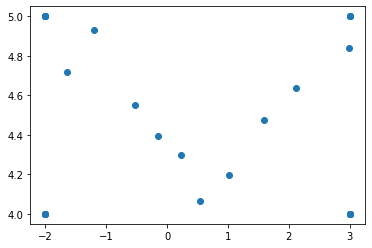

In [14]:
print("There are currently {} points in mySamples".format(len(mySamples.get_points()[:,0])))

NUM_POINTS_TO_ADD = 15
mySamples.generate_samples(['X', 'Y'], sampler.CornerSampler(), num_points=NUM_POINTS_TO_ADD)
print("Now there are {} points in mySamples".format(len(mySamples.get_points()[:, 0])))
plt.scatter(mySamples.get_points('X'), mySamples.get_points('Y'))

<p>We can also add variables after points have already been generated and  generate points on specific variables.</p>
<p>Here we add the variable 'Z' and then sample 25 points from a normal distribution on 'Z'</p>
<blockquote>Note: It's up to the user to ensure that the number of points in each dimension match.</blockquote>

In [15]:
mySamples.set_continuous_variable('Z', -1, 2, 3)
mySamples.generate_samples(['Z'], sampler.ProbabilityDensityFunctionSampler(),
                           num_points=25, dist='norm', loc=[1], scale=[.1])  # loc: mean, scale: standard deviation

print(mySamples.get_points(['X', 'Y', 'Z']))
print("The mean of 'Z' is {}".format(mySamples.get_points('Z').mean()))
print("The standard deviation of 'Z' is {}".format(mySamples.get_points('Z').std()))

[[-1.6467928016682647 4.717684177332469 0.9174789006300794]
 [-1.1999645904013851 4.932355352418508 0.9332947213960967]
 [-0.5363032324796249 4.552936651771095 0.9146029650556975]
 [-0.1516745254930323 4.393133117672512 0.9285692048555078]
 [1.0117994152258714 4.196231106949166 0.9835820127306313]
 [0.2201117766508247 4.299395971020031 0.9291487574416958]
 [1.5885084291701626 4.4749290656254805 1.1197568758720866]
 [2.1245754939249766 4.638726167257663 0.9278386677193665]
 [2.9871525010721944 4.837599370902022 0.9226305960368443]
 [0.5362919454792521 4.063876233633892 1.11303119058151]
 [-2.0 4.0 1.0038164707609039]
 [-2.0 5.0 0.9122557638030913]
 [3.0 4.0 0.850664202908764]
 [3.0 5.0 1.1104277201607113]
 [-2.0 4.0 1.028841071164789]
 [-2.0 5.0 0.922805813840874]
 [3.0 4.0 0.9757748089419751]
 [3.0 5.0 0.8308226639445921]
 [-2.0 4.0 1.0681363769767682]
 [-2.0 5.0 0.7348658001720132]
 [3.0 4.0 0.8441432755180188]
 [3.0 5.0 1.092613719485721]
 [-2.0 4.0 1.1085246493379926]
 [-2.0 5.0 0.9

<h2>Creating Your Own Sampler</h2>
<p>To implement your own sampler that can interact with the rest of the Trata sampling methods, your sampler must inherit from either ContinuousSampler, DiscreteSampler, or both. Which base class your sampler inherits from will depend what kind of variables it can handle.</p>
<p>At the class level, the variable <code>name</code> will hold the name of the Sampler, for use in the <code>str</code> and <code>repr</code> methods.</p>
<p>The only method you are required to implement is <code>sample_points()</code>. This method will contain the logic for generating points. It will take a set of arbitrary arguments and return a 2d numpy array, in which each row corresponds to a point.</p>
<p>Here we will define a new sampler that will return the numbers 1 to N in each dimension. It should take a number of points to generate <code>num_points</code> and the number of dimensions <code>num_dim</code> as its arguments</p>

In [16]:
import numpy as np


class RangeSampler(sampler.ContinuousSampler):
    name = 'Range'
    
    @staticmethod
    def sample_points(num_points, num_dim, **kwargs):
        
        return np.array([np.arange(1, int(num_points)+1)]*int(num_dim)).T

In [17]:
RangeSampler().sample_points(num_points=10, num_dim=3)

array([[ 1,  1,  1],
       [ 2,  2,  2],
       [ 3,  3,  3],
       [ 4,  4,  4],
       [ 5,  5,  5],
       [ 6,  6,  6],
       [ 7,  7,  7],
       [ 8,  8,  8],
       [ 9,  9,  9],
       [10, 10, 10]])

<p>Because we have followed the API, <code>RangeSampler</code> can now be used with <code>composite_samples</code></p>

In [18]:
newSamples = composite_samples.Samples()
newSamples.set_continuous_variable('x', 0, 0, 1)
newSamples.set_continuous_variable('y', 0, 0, 1)
newSamples.generate_samples(['x', 'y'], RangeSampler(), num_points=30, num_dim=2)
print(newSamples.get_points())


[[ 1.  1.]
 [ 2.  2.]
 [ 3.  3.]
 [ 4.  4.]
 [ 5.  5.]
 [ 6.  6.]
 [ 7.  7.]
 [ 8.  8.]
 [ 9.  9.]
 [10. 10.]
 [11. 11.]
 [12. 12.]
 [13. 13.]
 [14. 14.]
 [15. 15.]
 [16. 16.]
 [17. 17.]
 [18. 18.]
 [19. 19.]
 [20. 20.]
 [21. 21.]
 [22. 22.]
 [23. 23.]
 [24. 24.]
 [25. 25.]
 [26. 26.]
 [27. 27.]
 [28. 28.]
 [29. 29.]
 [30. 30.]]


<h3>The basic outline for implementing a sampler</h3>   
<code>    class ...(sampler.Sampler):
        name = ...
        @staticmethod
        def sample_points(...):
            ...
</code>